In [1]:
using Pkg; Pkg.activate(".")
using CSV
using DataFrames
using PyPlot
using LaTeXStrings
using MUST
using DelimitedFiles
using Statistics
using Polynomials
MUST.@import_dispatch "../../../dispatch2_clean/dispatch2"

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/running_dispatch/Project.toml`


PyObject <module 'dispatch' from '/cobra/ptmp/peitner/model_grid/dispatch2_clean/dispatch2/utilities/python/dispatch/__init__.py'>

In [2]:
results = DataFrame(CSV.File("summary_solar1.csv"));

In [3]:
t, rho, successP1, successP2 = eachcol(results[:,[:stellar_params!tt_k, :stellar_params!d_cgs, :phase1_success, :phase2_success]]);

# Phase 1 (firction)

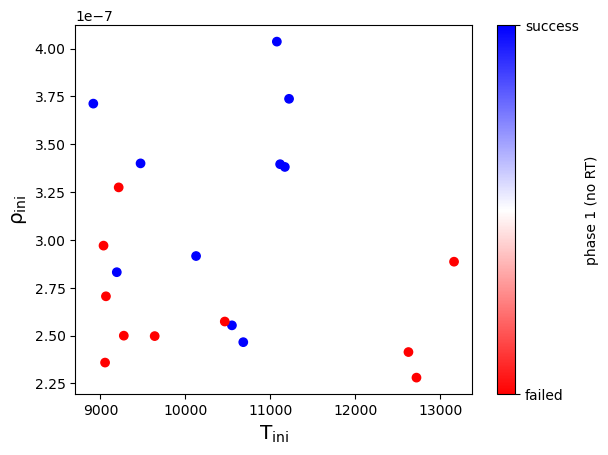

In [4]:
plt.close()
im = plt.scatter(t, rho, c=successP1, cmap="bwr_r", vmin=0, vmax=1)
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm \rho_{ini}", fontsize="x-large")
cbar = plt.colorbar(im)
cbar.set_label("phase 1 (no RT)")
cbar.set_ticks([0,1])
cbar.set_ticklabels(["failed", "success"])
#plt.savefig("t_rho_p1_success.png")

# Phase 2 (no friction)

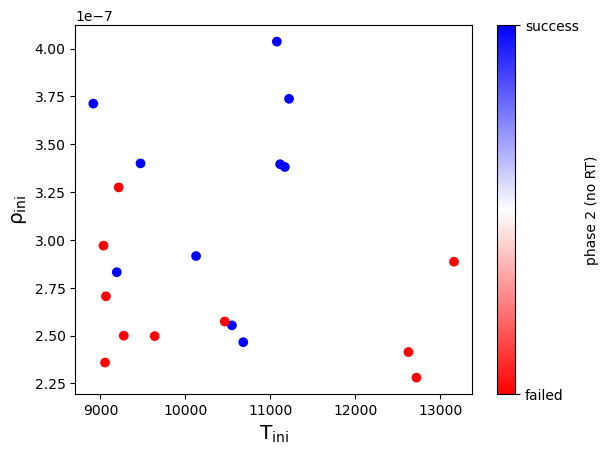

In [5]:
plt.close()
im = plt.scatter(t, rho, c=successP2, cmap="bwr_r", vmin=0, vmax=1)
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm \rho_{ini}", fontsize="x-large")
cbar = plt.colorbar(im)
cbar.set_label("phase 2 (no RT)")
cbar.set_ticks([0,1])
cbar.set_ticklabels(["failed", "success"])
plt.savefig("t_rho_p2_success.png")

# Effective temperature of successful runs

In [6]:
get_teff(folder) = begin
    path = joinpath(folder, "teff.dat")
    if !ispath(path) @warn "$(path) does not exist."
        return nothing
    end
    data = readdlm(path)
end 

get_teff (generic function with 1 method)

In [7]:
folders = [@MUST.in_dispatch(joinpath("data",r[1:first(findfirst(".nml",r))-1])) for r in results[results.phase2_success .== true, :phase2_name]];

In [8]:
teff = [get_teff(f) for f in folders];

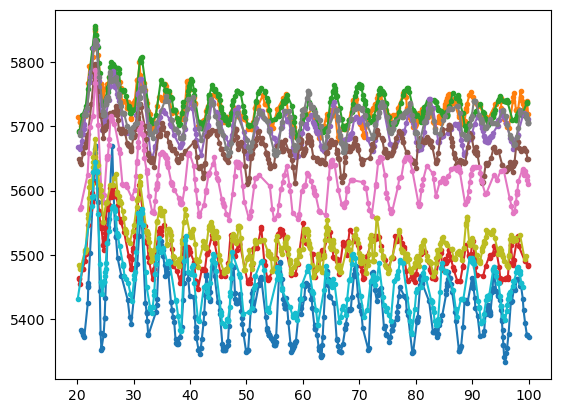

In [9]:
plt.close()
for r in teff
    isnothing(r) && continue
    
    plt.plot(r[:,1], r[:,2], marker=".")
end
#plt.ylim(4500,5750)
plt.savefig("teff.png")

In [10]:
teff_t = Float64[]
for t in teff
    try
        isnothing(t) ? append!(teff_t, [NaN]) : append!(teff_t, [mean(t[end-20:end,2])])
    catch
        append!(teff_t, [NaN])
    end
end


size(teff_t)

(10,)

In [11]:
t_success, rho_success = eachcol(results[results.phase2_success .== true, [:stellar_params!tt_k, :stellar_params!d_cgs]]);

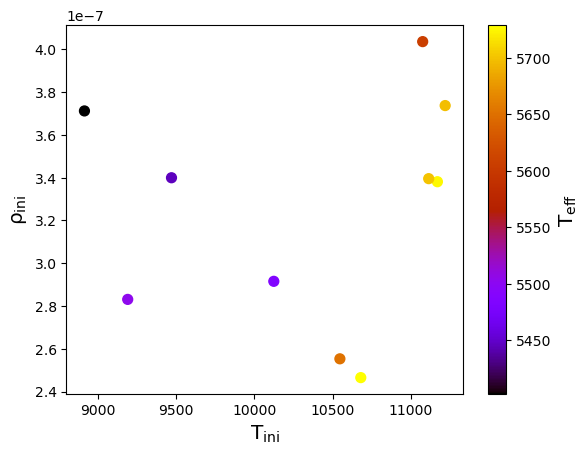

In [13]:
plt.close()
im = plt.scatter(t_success, rho_success, c=teff_t, cmap="gnuplot", s=50)
cbar = plt.colorbar(im)
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm \rho_{ini}", fontsize="x-large")
cbar.set_label(L"\rm T_{eff}", fontsize="x-large")
plt.savefig("t_rho_teff.png")

In [14]:
function get_initial(t_success, rho_success, teff; goal=5778.0)
    mask = .!isnan.(teff)
    linfit_t   = Polynomials.fit(t_success[mask], teff[mask], 1)
    linfit_rho = Polynomials.fit(log.(rho_success[mask]), teff[mask], 1)
    
    t_ini   = (goal - linfit_t.coeffs[1])/linfit_t.coeffs[2]
    rho_ini = (goal - linfit_rho.coeffs[1])/linfit_rho.coeffs[2]

    (t_ini, exp(rho_ini))
end

get_initial (generic function with 1 method)

In [15]:
get_initial(t_success, rho_success, teff_t)

(11783.380578653036, 7.51832193926092e-8)

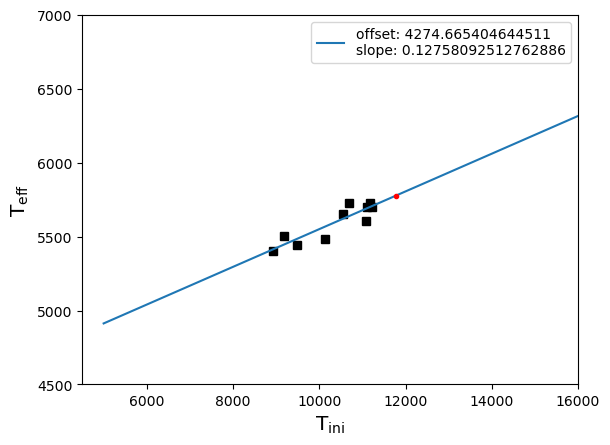

PyObject <matplotlib.legend.Legend object at 0x2ac5664f7d00>

In [16]:
plt.plot(t_success, teff_t, marker="s", ls="", color="k")
plt.xlabel(L"\rm T_{ini}", fontsize="x-large")
plt.ylabel(L"\rm T_{eff}", fontsize="x-large")

mask = .!isnan.(teff_t)
linfit = Polynomials.fit(t_success[mask], teff_t[mask], 1)
x = [5000:100:16000...]; y = linfit.coeffs[1] .+ linfit.coeffs[2] .* x 
plt.plot(x, y, label="offset: $(linfit.coeffs[1])\nslope: $(linfit.coeffs[2])")

plt.xlim(4500,16000)
plt.ylim(4500,7000)

plt.plot([get_initial(t_success, rho_success, teff_t)[1]],[5772], color="red", marker=".")

plt.legend()

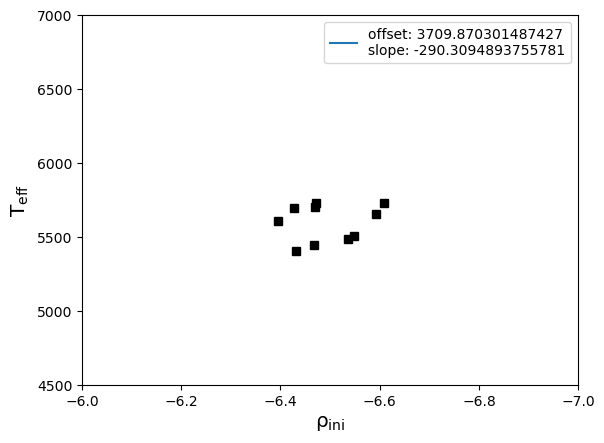

PyObject <matplotlib.legend.Legend object at 0x2ac56652d9a0>

In [17]:
plt.plot(log.(10,rho_success), teff_t, marker="s", ls="", color="k")
plt.xlabel(L"\rm \rho_{ini}", fontsize="x-large")
plt.ylabel(L"\rm T_{eff}", fontsize="x-large")

mask = .!isnan.(teff_t)
linfit = Polynomials.fit(log.(10,rho_success)[mask], teff_t[mask], 1)
x = [-18.0:0.1:-13.0...]; y = linfit.coeffs[1] .+ linfit.coeffs[2] .* x 
plt.plot(x, y, label="offset: $(linfit.coeffs[1])\nslope: $(linfit.coeffs[2])")

plt.xlim(-6,-7)
plt.ylim(4500,7000)

plt.plot([log(10, get_initial(t_success, rho_success, teff_t)[2])],[5778], color="red", marker=".")

plt.legend()

In [18]:
@info "Extrapolated (T,rho) = $(get_initial(t_success, rho_success, teff_t))"

┌ Info: Extrapolated (T,rho) = (11783.380578653036, 7.51832193926092e-8)
└ @ Main In[18]:1


In [19]:
log10(3.0445492234271924e-7)

-6.516477